<a href="https://colab.research.google.com/github/ngcheeyuan/Fraud_Detection_Capstone/blob/main/Capstone_Final_Model_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U scikit-learn
!pip install -U imbalanced-learn
!pip install plot_metric
!pip install category_encoders
!pip install distfit

     |████████████████████████████████| 82 kB 393 kB/s 


In [35]:
#preprocessing, pipelining
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import make_column_transformer , make_column_selector
from sklearn.metrics import balanced_accuracy_score, recall_score,precision_score,make_scorer,matthews_corrcoef,f1_score,confusion_matrix


#feature selection tools
from sklearn.feature_selection import VarianceThreshold,SelectKBest,f_classif,mutual_info_classif

#Data Imbalance tools
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

#utility
import pandas as pd
import numpy as np
import pickle

#models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from imblearn.ensemble import RUSBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from distfit import distfit

#model selection
from sklearn.model_selection import  GridSearchCV

#plotting
from plot_metric.functions import BinaryClassification
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_tree
from xgboost import to_graphviz
from xgboost import plot_importance
from sklearn import set_config

In [3]:
set_config(display="diagram")

### Setting up training and validation 

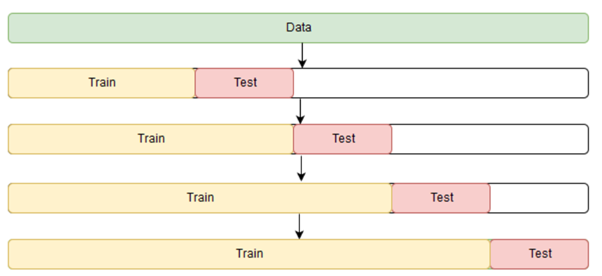

In [4]:
#Custom training/validation split
def rolling_forecast_origin(X_train): 
  '''
  creating a generator function to produce a rolling forecast window, increasing training data by 1 months and validating on 1 months after.
  
  '''
  for month in range(1,13):
    if month > 1:
      X_split_train = X_train.loc['2012-2':f'2014-{month-1}']
      X_split_val = X_train.loc[f'2014-{month}']
    
    else:
      X_split_train = X_train.loc['2012-2':'2013-12']
      X_split_val = X_train.loc['2014-01']

    yield X_split_train,X_split_val

In [5]:
def rolling_forecast_test(X_train,X_test,y_train,y_test): 
  '''  
  creating a generator function to produce a rolling forecast window, increasing training data by 1 months and test on 1 months after.
  '''
  
  for month in range(1,13):
    if month > 1:
      X_split_train = X_test.loc['2015-1':f'2015-{month-1}']
      X_split_train = pd.concat([X_train,X_split_train], axis = 0)
      X_split_test = X_test.loc[f'2015-{month}']

      y_split_train = y_test.loc['2015-1':f'2015-{month-1}']
      y_split_train = pd.concat([y_train,y_split_train], axis = 0)
      y_split_test = y_test.loc[f'2015-{month}']
    
    else:
      X_split_train = X_train
      X_split_test = X_test.loc['2015-01']

      y_split_train = y_train
      y_split_test = y_test.loc['2015-01']



    yield X_split_train,X_split_test,y_split_train,y_split_test

In [272]:
def rolling_test(model,cv,model_name,threshold):
  '''
  Computing prediction scores for expanding training set window and test set scores.
  '''
  scoring_list = []

  for month,(X_split_train,X_split_test,y_split_train,y_split_test) in enumerate(cv,1):
    train_preds = (model.predict_proba(X_split_train)[:,1] >= threshold).astype(bool)
    test_preds = (model.predict_proba(X_split_test)[:,1] >= threshold).astype(bool)
    tn, fp, fn, tp = confusion_matrix(y_split_test, test_preds).ravel()


    test  = pd.DataFrame({'amt':X_split_test['amt'].values,
                          'is_fraud':y_split_test.values,
                          'test_preds': test_preds
                        })
    
    mask = test['is_fraud'] == 1
    mask1 = test['test_preds'] == 0 # false negative

    fraud_chargebacks = test[mask&mask1]['amt'].sum()

    mask = test['is_fraud'] == 1
    mask1 = test['test_preds'] == 1 #True positive
    fraud_amt = test[mask&mask1]['amt'].sum()  

    train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1 = scoring_generator(y_split_train,y_split_test,train_preds,test_preds)


    new_row ={'model':model_name,'month':month,
              'train_acc':train_acc,'train_prec':train_prec,'train_rec':train_rec,'train_f1':train_f1,  #train metric
              'test_acc':test_acc,'test_prec':train_prec,'test_rec':train_rec,'test_f1':test_f1,  #test metric
              'TP':tp,'TN':tn,'FP':fp,'FN':fn, 'chargebacks':fraud_chargebacks, 'chargebacks_avoided':fraud_amt
              }
    
    scoring_list.append(new_row)
   

    #display(scording_df.append(new_row,ignore_index = True))

  return pd.DataFrame(scoring_list)

In [7]:
def scoring_generator(y_tr,y_t,train_preds,test_preds):
  '''
  subroutine to compute relevant scores.
  '''
    train_acc = balanced_accuracy_score(y_tr,train_preds) #train metrics
    train_prec = precision_score(y_tr,train_preds)
    train_rec = recall_score(y_tr,train_preds)
    train_f1 = f1_score(y_tr,train_preds)

    test_acc = balanced_accuracy_score(y_t,test_preds) #test metrics
    test_prec = precision_score(y_t,test_preds)
    test_rec = recall_score(y_t,test_preds)
    test_f1 = f1_score(y_t,test_preds)

    return train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1

In [8]:
def cv_generator(cv):
  '''
  custom cross validation function
  '''
  cv_list = []

  for x_train,x_val in cv:
    z_train = x_train.reset_index() # gridsearchCV does not accept dates as index, resetting to remove dates as index
   
    adjustments = z_train.index[-1] 

    z_val = x_val.reset_index()
    z_val.index += adjustments + 2 #s reset_index() will make index start from 0, the value of the last of row + 2 is added to the index value as adjustments.

    cv_list.append((z_train.index,z_val.index[:-1]))
  
  return cv_list

In [9]:
scoring_df = pd.DataFrame(columns = ['model','train_acc','test_acc','train_prec','test_prec','train_rec','test_rec','train_f1','test_f1'])


def print_results(model,X_tr,X_t,y_tr,y_t,model_name):
    '''
    Function used in other functions to print and store model metrics.
    '''

    train_preds = model.predict(X_tr)
    test_preds = model.predict(X_t)

    train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1 = scoring_generator(y_tr,y_t,train_preds,test_preds)

    new_row ={'model':model_name,
              'train_acc':train_acc,'train_prec':train_prec,'train_rec':train_rec,'train_f1':train_f1,  #train metric
              'test_acc':test_acc,'test_prec':train_prec,'test_rec':train_rec, 'test_f1':test_f1 #test metric
              }

    print(f'train - balanced acc : {train_acc} , precision : {train_prec} , recall: {train_rec}, f1: {train_f1}')
    print(f'test - balanced acc : {test_acc} , precision : {test_prec} , recall: {test_rec}, f1: {test_f1}')

    return new_row

In [10]:
def evaluation_plot(model,X_tr,X_t,y_tr,y_t,model_name):
  '''
  plotting  models
  '''
  train_preds = model.predict(X_tr)
  test_preds = model.predict(X_t)

  train_proba= model.predict_proba(X_tr)
  test_proba = model.predict_proba(X_t)

  new_row = print_results(model,X_tr,X_t,y_tr,y_t,model_name)

  plt.figure(figsize=(24,12))
  bc = BinaryClassification(y_tr, train_proba[::,1], labels=["Not Fraud", "Fraud"])
  bc1 = BinaryClassification(y_t, test_proba[::,1], labels=["Not Fraud", "Fraud"])

  #plotting ROC-AUC curve
  plt.subplot2grid(shape=(3,12), loc=(0,0), colspan=3)
  bc.plot_roc_curve(title = 'Training - ROC')
  plt.subplot2grid(shape=(3,12), loc=(0,3), colspan=3)
  bc1.plot_roc_curve(title  = 'Testing - ROC')
  
  #plotting Precission-recall curve
  plt.subplot2grid((3,12), (1,0), colspan=3)
  bc.plot_precision_recall_curve(title = 'Training - Precision -Recall Curve')
  plt.subplot2grid((3,12), (1,3), colspan=3)
  bc1.plot_precision_recall_curve(title = 'Testing - Precision -Recall Curve')

  #plot confusion matrix
  plt.subplot2grid((3,12), (0,6), colspan=3)
  bc.plot_confusion_matrix(title ='Training')
  plt.subplot2grid((3,12), (0,9), colspan=3)
  bc1.plot_confusion_matrix(title = 'Testing')

  
  #plot confusion matrix with the values normalized
  plt.subplot2grid((3,12), (1,6), colspan=3)
  bc.plot_confusion_matrix(title ='Training' , normalize = True)
  plt.subplot2grid((3,12), (1,9), colspan=3)
  bc1.plot_confusion_matrix(title = 'Testing', normalize = True)

  return new_row

In [11]:
def plot_cross_val_results(gs,X_tr,y_tr):
  print(f'best params {gs.best_params_}')

  '''
  plotting model performance on each fold of our cross validation.
  '''
  train_preds = gs.predict(X_tr)

  train_acc = balanced_accuracy_score(y_tr,train_preds) #train metrics
  train_prec = precision_score(y_tr,train_preds)
  train_rec = recall_score(y_tr,train_preds)
  train_f1 = f1_score(y_tr,train_preds)
  
  scores = pd.DataFrame(gs.cv_results_).filter(items = ['mean_test_balanced_accuracy', 'mean_test_precision','mean_test_recall', 'mean_test_f1',
                                                        'rank_test_balanced_accuracy','rank_test_precision','rank_test_recall', 'rank_test_f1'])
  
  mask = scores['rank_test_balanced_accuracy']==1
  val_acc = scores.loc[mask,'mean_test_balanced_accuracy'].values[0]
  val_prec = scores.loc[mask,'mean_test_precision'].values[0]
  val_rec = scores.loc[mask,'mean_test_recall'].values[0]
  val_f1 = scores.loc[mask,'mean_test_f1'].values[0]
  

  print(f'train           - balanced acc : {train_acc} , precision : {train_prec} , recall: {train_rec}, f1: {train_f1}')
  print(f'mean validation - balanced acc : {val_acc} , precision : {val_prec} , recall: {val_rec}, f1: {val_f1}')

  fig,ax = plt.subplots(nrows = 2, ncols =2,figsize = (24,12))

  for i,metric in enumerate(['balanced_accuracy','precision','recall','f1']):

    row = i//2 #when i = 0,1, i//2 == 0 when i = 2, i//2 == 1
    col = i%2  #if i is odd, col == 1, if i is even col = 0 
    
    #plot each scoring metricfor every for each validation fold
    pd.DataFrame(gs.cv_results_).drop(columns = [f'rank_test_{metric}',f'mean_test_{metric}',f'std_test_{metric}'],axis = 'columns')\
                                        .filter(like =f'test_{metric}').T\
                                        .plot(ax = ax[row,col], legend = False).set_title(f'{metric}')
    ax[row,col].set_xticks(range(12))
    ax[row,col].set_xticklabels(range(1,13))
    ax[row,col].set_xlabel('split')

    #ax[row,col].legend(loc='upper right')
    ax[row,col].set_ylim([0, 1])
  return gs.best_score_

In [12]:
def get_threshold(gs,X_tr,X_t,y_tr,y_t):
  '''
  Compute performance metrics of models at different thresholds
  '''
  df_temp =pd.DataFrame({})
  ts_dict = {}

  for threshold in np.linspace(0,1,101) :
    test_preds = (gs.predict_proba(X_test)[:,1] >= threshold).astype(bool)
    train_preds = (gs.predict_proba(X_tr)[:,1]  >= threshold).astype(bool)
    train_acc,train_prec,train_rec,train_f1,_,_,_,_ = scoring_generator(y_tr,y_t,train_preds,test_preds)

    tn, fp, fn, tp = confusion_matrix(y_tr, train_preds).ravel()

    temp = pd.DataFrame({'threshold':[threshold],
                         'balance_acc':[train_acc],
                         'precision':[train_prec],
                         'recall':[train_rec],
                         'f1':[train_f1],
                         'TP':[tp],
                         'TN':[tn],
                         'FP':[fp],
                         'FN':[fn]
                         })
    
    ts_dict[threshold] = temp

  df_temp = pd.concat(ts_dict.values(),ignore_index=True)


  return df_temp

In [13]:
def down_cast(df_): 
  '''
  Down casting dataframe to reduce memory usage
  '''
  cat_columns = ['city','state','merchant','job','category','name','cc_num']
  df_[cat_columns] = df_[cat_columns].astype('category')
  unsigned_int = ['is_fraud','trans_year','trans_month','weekday','hour','day','age_at_trans','age_bin','time_risk','flag_cat_amt']
  df_[unsigned_int] = df_[unsigned_int].apply(pd.to_numeric, downcast='unsigned')
  fcols = df_.select_dtypes('float').columns
  df_[fcols] = df_[fcols].apply(pd.to_numeric, downcast='float')

  return df_

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Reading in data

In [15]:
DATA_PATH = "/content/drive/MyDrive/Capstone Dataset/"

In [16]:
df_train = pd.read_csv(DATA_PATH+'train_engineered.csv')
df_test = pd.read_csv(DATA_PATH+'test_engineered.csv')

In [17]:
df_train.fillna(0,inplace = True )
df_test.fillna(0,inplace = True )

In [18]:
df_train['trans_date_time'] = pd.to_datetime(df_train['trans_date_time'])
df_train.sort_values(by = 'trans_date_time', inplace = True)
df_train.set_index('trans_date_time',inplace = True)
df_test['trans_date_time'] = pd.to_datetime(df_test['trans_date_time'])
df_test.sort_values(by = 'trans_date_time', inplace = True)
df_test.set_index('trans_date_time',inplace = True)

In [19]:
df_train.loc[:,'previous_month_trans'] = df_train.loc[:,'previous_month_trans'].map(lambda x : 0 if x>0 else 1)
df_test.loc[:,'previous_month_trans'] = df_test.loc[:,'previous_month_trans'].map(lambda x : 0 if x>0 else 1)

In [20]:
df_train = down_cast(df_train)
df_test = down_cast(df_test)

In [21]:
df_train.columns

Index(['cc_num', 'city', 'state', 'job', 'trans_date', 'category', 'amt',
       'is_fraud', 'merchant', 'trans_year', 'trans_month', 'weekday', 'hour',
       'day', 'age_at_trans', 'name', 'age_bin', 'ln_amt', 'time_risk',
       'cardholder_to_merc_dist', 'flag_cat_amt', 'trans_shift',
       'ewm_60trans_mean', 'ewm_60trans_std', 'travel_speed',
       'previous_month_trans'],
      dtype='object')

In [22]:
features = ['category','merchant','amt','trans_month','weekday','time_risk','age_bin','flag_cat_amt','ln_amt','previous_month_trans']

In [23]:
X_train = df_train.loc[:,features].copy()
y_train = df_train.loc[:,'is_fraud'].copy()

X_test = df_test.loc[:,features].copy()
y_test= df_test.loc[:,'is_fraud'].copy()

### Setting up Pipeline

In [71]:
tgt = TargetEncoder(smoothing = 50)
ohe = OneHotEncoder()
scaler = MinMaxScaler()
#sm = SMOTENC(random_state=42,sampling_strategy = 0.15, categorical_features=[0,1,2,3]) # not enough ram to run this.
var = VarianceThreshold(threshold=(.975 * (1 - .975))) # remove all features that are 95% 0 or 1


ctf = make_column_transformer((scaler,make_column_selector(dtype_include=np.number)),
                              (tgt,['merchant','category']),# run mix-max scaler on numerical data type, saga solver requires a scaled dataset.
#                              (ohe,['category']), #One hot encode object daatype
                              remainder = 'passthrough')


ratio = 0.15
over = RandomOverSampler(sampling_strategy = ratio)
under = RandomUnderSampler(sampling_strategy = 0.65)


weight = 1/ratio

isf_model = make_pipeline(ctf,
                          IsolationForest(contamination = y_train.mean()))

lf_model = make_pipeline(ctf, LocalOutlierFactor(novelty=True))

log_model = make_pipeline(ctf,
#                         var,
                          over,
#                         under,  
                          LogisticRegression(class_weight='balanced', 
                                             max_iter = 1000, 
                                             solver = 'saga', 
                                             tol = 0.1,
                                             random_state = 42)) #using class weights to adjust for class imbalance

svm = make_pipeline(ctf,
                    over,
                    CalibratedClassifierCV(base_estimator =SGDClassifier(tol = 0.1)))

### Anomaly Detection with Isolation Forest 

Isolation forest is an algorithmn designed to detect anomalies in the dataset The paper proposed that outliers are easier to isolate, compared to inlier when growing a decision tree.

original paper: https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf?q=isolation-forest

In [25]:
isf_model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f3c9f40b650>),
                                                 ('targetencoder',
                                                  TargetEncoder(smoothing=50.0),
                                                  ['merchant', 'category'])])),
                ('isolationforest',
                 IsolationForest(contamination=0.0027080028171906478))])

In [26]:
train_preds = isf_model.predict(X_train)
test_preds =isf_model.predict(X_test)

In [27]:
X_train['if_class'] =train_preds
X_test['if_class'] =test_preds

X_train['if_class'] = X_train.loc[:,'if_class'].map(lambda x : 1 if x==-1 else 0)
X_test['if_class'] = X_test.loc[:,'if_class'].map(lambda x : 1 if x==-1 else 0)

In [28]:
confusion_matrix(df_train['is_fraud'],X_train['if_class'])

array([[1376997,    2196],
       [   2196,    1549]])

The model is able to pick up 5956 outliers in our dataset, where 1534 happens to be fraudulents transactions.

We will be using the output of the isolation forest algorithmn as a feature in our classification model.

### Logistic Regression

In [29]:
rolling_cv = rolling_forecast_origin(X_train)
cv = cv_generator(rolling_cv)

pipe_params = {'logisticregression__C':np.linspace(0.01,0.1,5)} #tested 0.01 to 0.1

scoring = {'balanced_accuracy' : make_scorer(balanced_accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score),
           'f1' : make_scorer(f1_score)}


log_gs = GridSearchCV(log_model, # what object are we optimizing?
                      param_grid=pipe_params, # what parameters values are we searching?
                      cv=cv, # custom folds 
                      scoring = scoring,
                      verbose = False,
                      refit = 'balanced_accuracy') 

In [30]:
infile = open(DATA_PATH+'logistic_regression','rb')
log_gs = pickle.load(infile)
#with open('logistic_regression' , 'rb') as f:
#    log_gs = pickle.load(f)

In [31]:
log_gs

GridSearchCV(cv=[(RangeIndex(start=0, stop=897552, step=1),
                  RangeIndex(start=897553, stop=923799, step=1)),
                 (RangeIndex(start=0, stop=923799, step=1),
                  RangeIndex(start=923800, stop=947795, step=1)),
                 (RangeIndex(start=0, stop=947795, step=1),
                  RangeIndex(start=947796, stop=983306, step=1)),
                 (RangeIndex(start=0, stop=983306, step=1),
                  RangeIndex(start=983307, stop=1016432, s...
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=42,
                                                           solver='saga',
                                                           tol=0.1))]),
             param_grid={'logisticregression__C': array([0.01  , 0.0325, 0.055 , 0.0775, 0.1   ])},
             refit='balanced_accuracy',
             scoring={'balanced_accuracy': make_scorer(balanced_accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)},
             verbose=False)

In [32]:
#log_gs.fit(X_train,y_train) #run this if you want to test my programme

In [33]:
#with open('logistic_regression', 'wb') as files:
#    pickle.dump(log_gs, files)

best params {'logisticregression__C': 0.1}
train           - balanced acc : 0.9166523631550691 , precision : 0.03816098238899141 , recall: 0.8945260347129506, f1: 0.07319924397198764
mean validation - balanced acc : 0.9018398395385255 , precision : 0.030639625133408874 , recall: 0.8783478945786332, f1: 0.05888399958151421


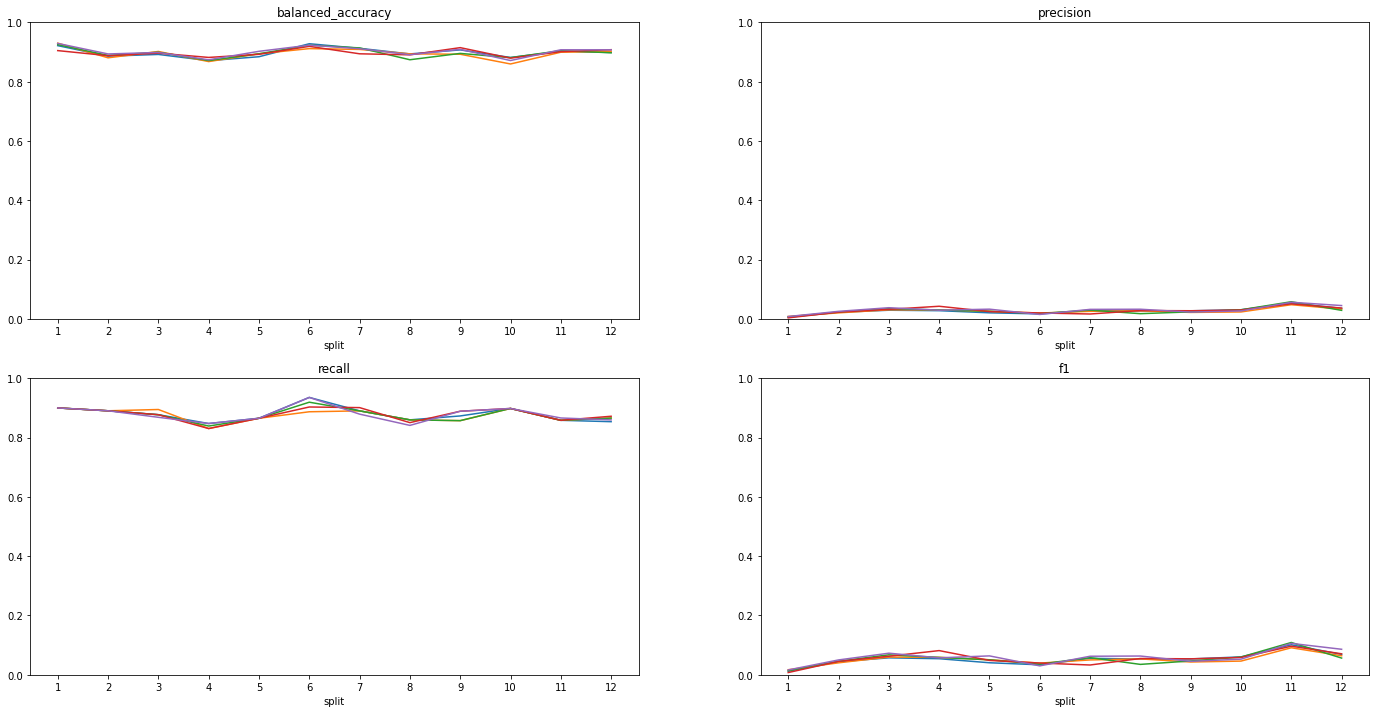

In [34]:
best_score = plot_cross_val_results(log_gs,X_train,y_train)

train - balanced acc : 0.9166523631550691 , precision : 0.03816098238899141 , recall: 0.8945260347129506, f1: 0.07319924397198764
test - balanced acc : 0.9137315357139388 , precision : 0.03873393691588785 , recall: 0.887123745819398, f1: 0.07422694836994542


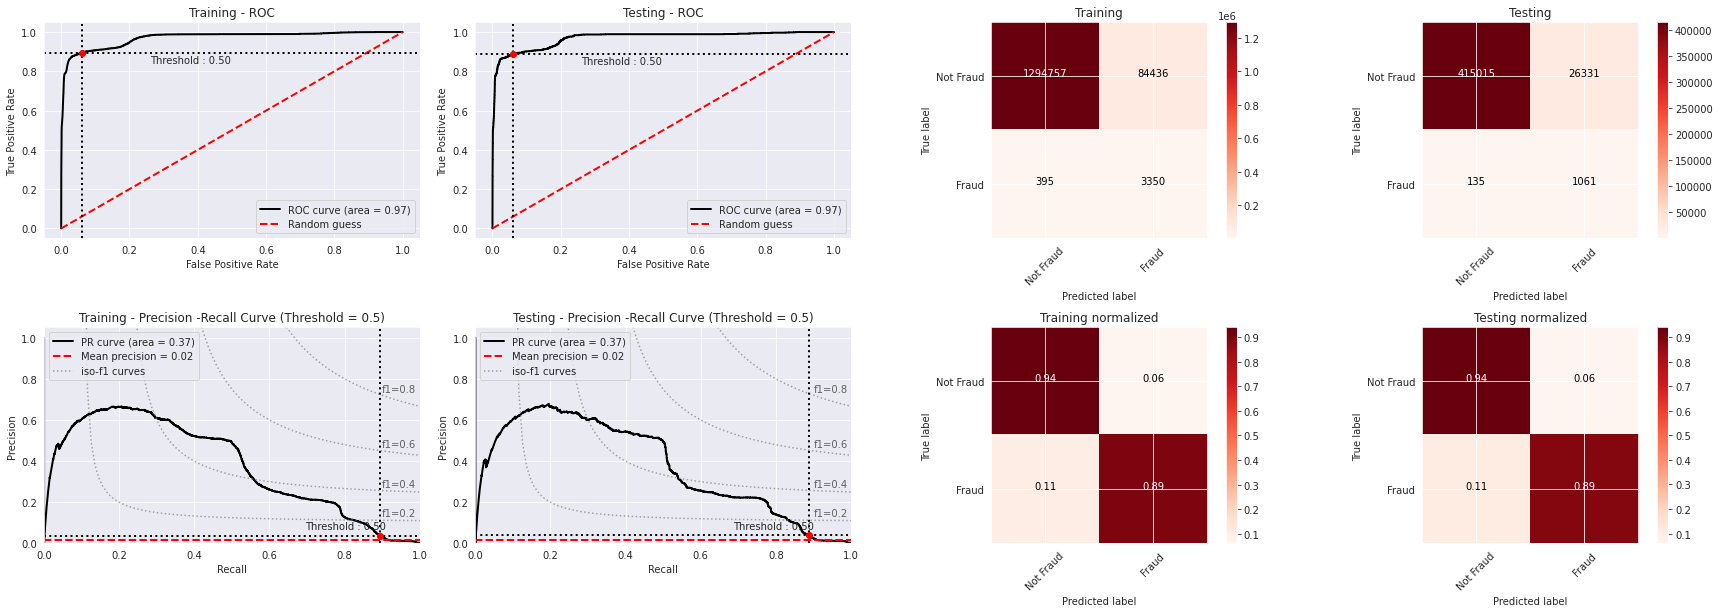

In [84]:
new_row = evaluation_plot(log_gs,X_train,X_test,y_train,y_test,'Logistic')

In [92]:
scoring_df = scoring_df.append(new_row,ignore_index = True) #storing scores

In [85]:
log_scores = get_threshold(log_gs,X_train,X_test,y_train,y_test)

In [191]:
log_scores['projected_chargebacks'] = average_fraud_amt*log_scores['FN']
log_scores['fp_cost'] = 100*log_scores['FP'] 
log_scores['cost'] = 0*log_scores['TP'] + 0*log_scores['TN'] + log_scores['fp_cost']+ log_scores['projected_chargebacks']

In [171]:
log_scores.sort_values(by = 'cost').head(1)

,threshold,balance_acc,precision,recall,f1,TP,TN,FP,FN,cost,projected_chargebacks
99,0.99,0.751065,0.481245,0.503605,0.492171,1886,1377160,2033,1859,1.190531e+06,987231.344849


To minimize total cost to the company, the ideal threshold to use when deploying this model, should be at around 0.99

In [274]:
cv = rolling_forecast_test(X_train,X_test,y_train,y_test)
log_test_score = rolling_test(log_gs,cv,'logistic regression',0.99)

In [275]:
log_test_score['fp_cost'] = 100*log_test_score['FP'] 
log_test_score['estimated_chargebacks'] = average_fraud_amt*log_test_score['FN']
log_test_score['projected_cost'] = 0*log_test_score['TP'] + 0*log_test_score['TN'] + log_test_score['fp_cost'] + log_test_score['estimated_chargebacks']
log_test_score['total_actual_cost'] = 0*log_test_score['TP'] + 0*log_test_score['TN'] + log_test_score['fp_cost']+ log_test_score['chargebacks']
log_test_score['average_chargebacks'] = log_test_score['chargebacks']/log_test_score['FN']

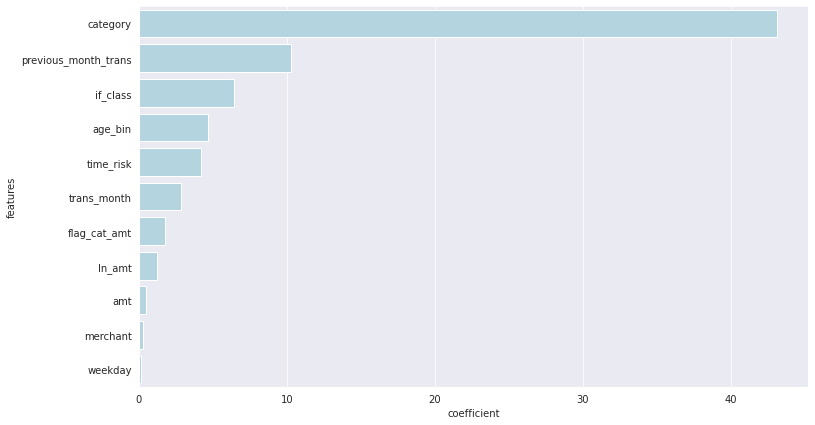

In [91]:
importance =log_gs.best_estimator_.named_steps["logisticregression"].coef_[0]
feature_importance = pd.DataFrame({'features' :X_train.columns,
                                   'coefficient' : abs(importance)}).sort_values(by='coefficient', ascending = False)
feature_importance['rank'] = feature_importance['coefficient'].rank(ascending = False)                                 
plt.figure(figsize = (12,7))  
sns.barplot( y= feature_importance['features'], x = feature_importance['coefficient'], orient = 'h', color = 'lightblue');

### SVM

In [74]:
rolling_cv = rolling_forecast_origin(X_train)
cv = cv_generator(rolling_cv)

pipe_params = {}

scoring = {'balanced_accuracy' : make_scorer(balanced_accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score),
           'f1' : make_scorer(f1_score)}


svm_gs = GridSearchCV(svm, # what object are we optimizing?
                      param_grid=pipe_params, # what parameters values are we searching?
                      cv=cv, # custom folds 
                      scoring = scoring,
                      verbose = False,
                      refit = 'balanced_accuracy') 

In [75]:
svm_gs.fit(X_train,y_train)

GridSearchCV(cv=[(RangeIndex(start=0, stop=897552, step=1),
                  RangeIndex(start=897553, stop=923799, step=1)),
                 (RangeIndex(start=0, stop=923799, step=1),
                  RangeIndex(start=923800, stop=947795, step=1)),
                 (RangeIndex(start=0, stop=947795, step=1),
                  RangeIndex(start=947796, stop=983306, step=1)),
                 (RangeIndex(start=0, stop=983306, step=1),
                  RangeIndex(start=983307, stop=1016432, s...
                                        RandomOverSampler(sampling_strategy=0.15)),
                                       ('calibratedclassifiercv',
                                        CalibratedClassifierCV(base_estimator=SGDClassifier(tol=0.1)))]),
             param_grid={}, refit='balanced_accuracy',
             scoring={'balanced_accuracy': make_scorer(balanced_accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)},
             verbose=False)

best params {}
train           - balanced acc : 0.8250762312575706 , precision : 0.23124705882352942 , recall: 0.6560747663551402, f1: 0.3419624217118998
mean validation - balanced acc : 0.827031031935697 , precision : 0.20591598498813649 , recall: 0.6604319293850553, f1: 0.30565669254989086


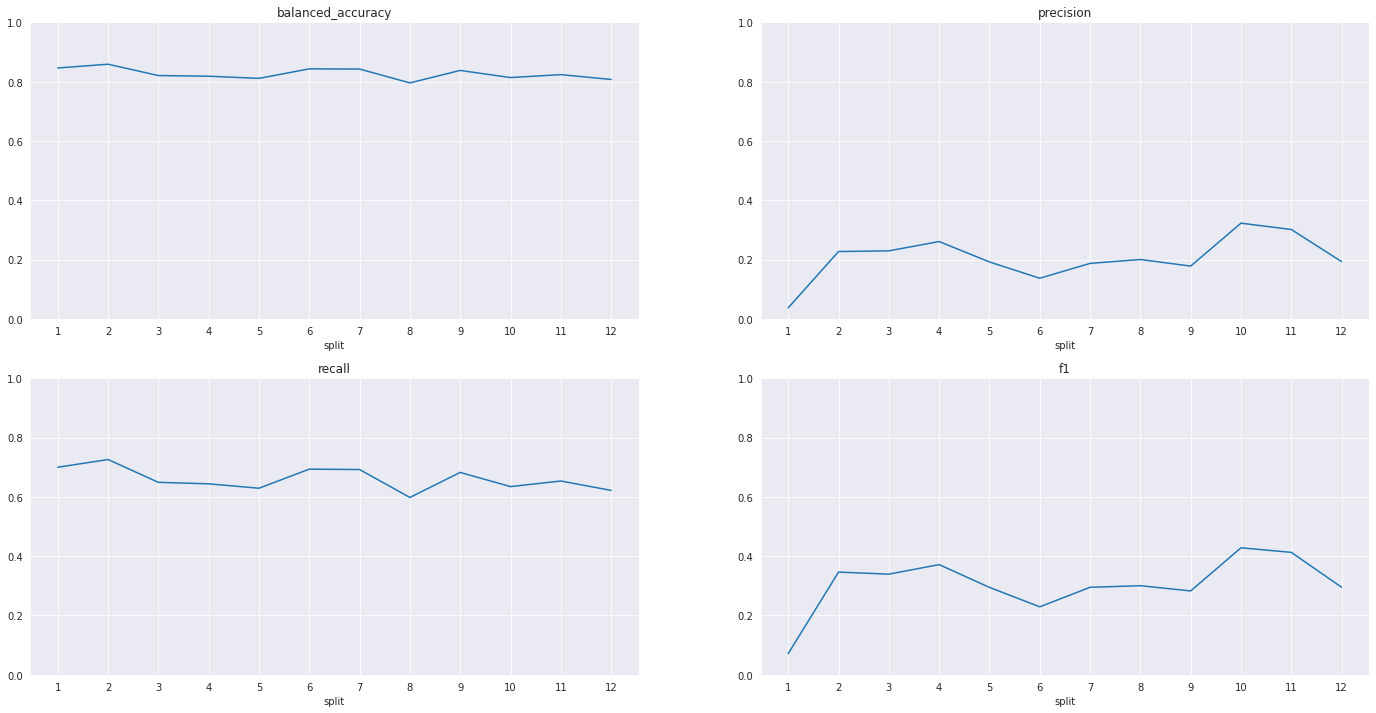

In [76]:
best_score = plot_cross_val_results(svm_gs,X_train,y_train)

train - balanced acc : 0.8250762312575706 , precision : 0.23124705882352942 , recall: 0.6560747663551402, f1: 0.3419624217118998
test - balanced acc : 0.821187068482373 , precision : 0.23809523809523808 , recall: 0.6479933110367893, f1: 0.34823635138171194


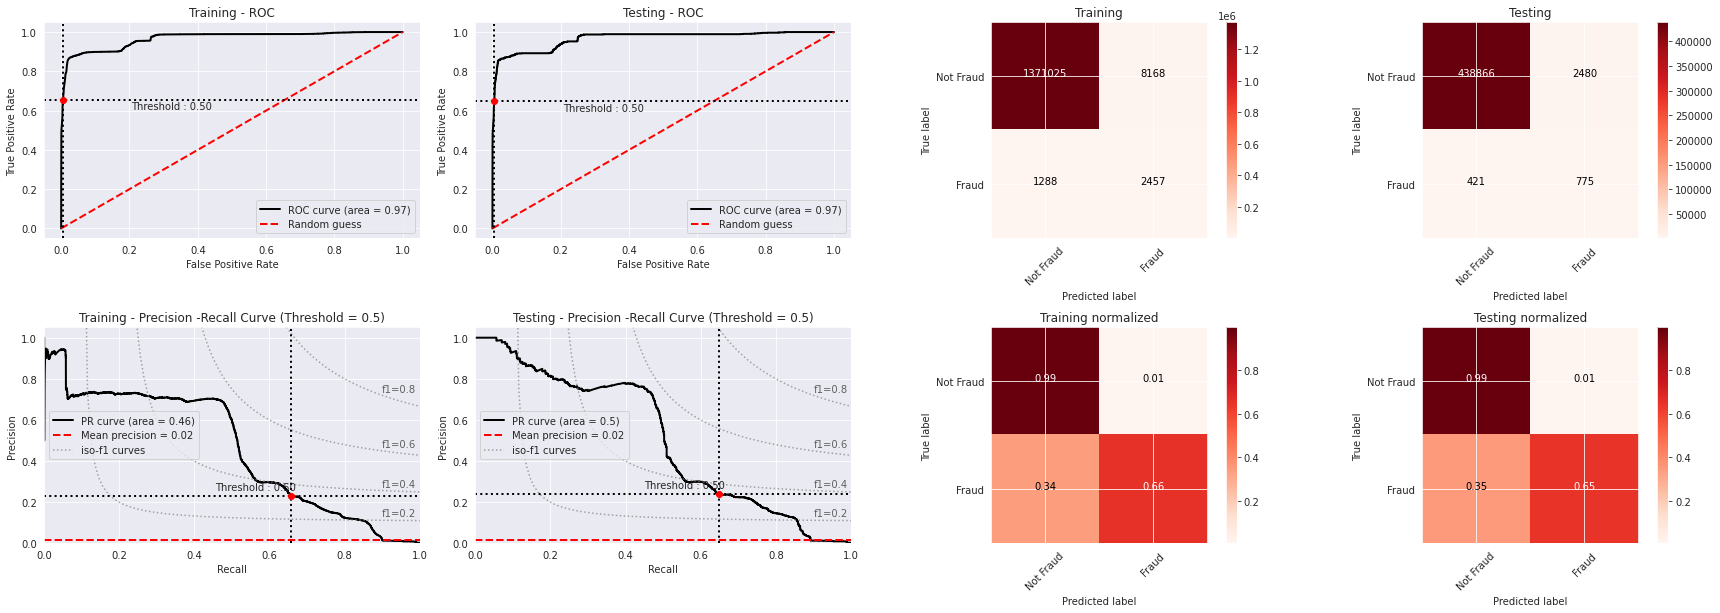

In [93]:
new_row = evaluation_plot(svm_gs,X_train,X_test,y_train,y_test,'svm')

In [78]:
svm_scores = get_threshold(svm_gs,X_train,X_test,y_train,y_test)

In [190]:
svm_scores['projected_chargebacks'] = average_fraud_amt*svm_scores['FN']
svm_scores['fp_cost'] = 100*svm_scores['FP']
svm_scores['cost'] = 0*svm_scores['TP'] + 0*svm_scores['TN'] + svm_scores['fp_cost'] + svm_scores['projected_chargebacks']
svm_scores.sort_values(by = 'cost').head(1)

,threshold,balance_acc,precision,recall,f1,TP,TN,FP,FN,cost,projected_chargebacks,fp_cost
90,0.9,0.742118,0.660364,0.484913,0.559199,1816,1378259,934,1929,1.117805e+06,1.024405e+06,93400


To minimize total cost to the company, the ideal threshold to use when deploying this model, should be at around 0.90

In [283]:
cv = rolling_forecast_test(X_train,X_test,y_train,y_test)
svm_test_score = rolling_test(svm_gs,cv,'svm',0.9)

In [284]:
svm_test_score['fp_cost'] = 100*svm_test_score['FP']
svm_test_score['estimated_chargebacks'] = average_fraud_amt*svm_test_score['FN']
svm_test_score['projected_cost'] = 0*svm_test_score['TP'] + 0*svm_test_score['TN'] + svm_test_score['fp_cost'] + svm_test_score['estimated_chargebacks']
svm_test_score['total_actual_cost'] = 0*svm_test_score['TP'] + 0*svm_test_score['TN'] + svm_test_score['fp_cost'] + svm_test_score['chargebacks']
svm_test_score['average_chargebacks'] = svm_test_score['chargebacks']/svm_test_score['FN']

In [94]:
scoring_df = scoring_df.append(new_row,ignore_index = True) #storing scores

In [95]:
rolling_cv = rolling_forecast_origin(X_train)
cv = cv_generator(rolling_cv)

xgb = XGBClassifier(tree_method = 'hist',   
      max_delta_step = 10,
      subsample = 0.5,colsample_by_tree = 0.5, 
      min_child_weight = 30,gamma = 30,
      objective = 'binary:logistic',
      random_state = 42
#     scale_pos_weight = weight #and provide a weight to adjust for the class imbalance
      )

skb = SelectKBest(score_func = f_classif)


xgboost_model = make_pipeline(ctf,                                  #transform columns
                              over,                                 #over sample positive class
                              var,                                                            
#                             under
#                              skb,                                  #simple feature selection process by filter
                              xgb)


pipe_params = {#'selectkbest__k':[6],
               'xgbclassifier__max_depth':[3],
               'xgbclassifier__gamma':[100],
               'xgbclassifier__min_child_weight':[100]}

scoring = {'balanced_accuracy' : make_scorer(balanced_accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score),
           'f1' : make_scorer(f1_score)
          }


xgb_gs = GridSearchCV(xgboost_model, # what object are we optimizing?
                      param_grid=pipe_params, # what parameters values are we searching?
                      cv=cv, # custom folds z
                      scoring = scoring,
                      verbose = False,
                      refit = 'balanced_accuracy')

In [124]:
infile2 = open(DATA_PATH+'xgb_gs','rb')
xgb_gs = pickle.load(infile2)

In [98]:
#xgb_gs.fit(X_train,y_train)

In [99]:
#with open('xgb_gs', 'wb') as files:
#    pickle.dump(xgb_gs, files)

In [119]:
mask = df_train['is_fraud'] ==1
average_fraud_amt = df_train[mask]['amt'].mean()

In [102]:
xgb_scores = get_threshold(xgb_gs,X_train,X_test,y_train,y_test)

In [194]:
xgb_scores['projected_chargebacks'] = average_fraud_amt*xgb_scores['FN']
xgb_scores['fp_cost'] = 100*xgb_scores['FP']
xgb_scores['cost'] = 0*xgb_scores['TP'] + 0*xgb_scores['TN'] + xgb_scores['fp_cost'] + xgb_scores['projected_chargebacks']

In [295]:
xgb_scores.sort_values(by = 'cost').head(1)

,threshold,balance_acc,precision,recall,f1,TP,TN,FP,FN,cost,projected_chargebacks,fp_cost
89,0.89,0.829024,0.503669,0.659813,0.571263,2471,1376758,2435,1274,920064.138428,676564.138428,243500


To minimize total cost to the company, the ideal threshold to use when deploying this model, should be at around 0.89

best params {'xgbclassifier__gamma': 100, 'xgbclassifier__max_depth': 3, 'xgbclassifier__min_child_weight': 100}
train           - balanced acc : 0.9299185551375002 , precision : 0.167944430151788 , recall: 0.8715620827770361, f1: 0.28162208800690247
mean validation - balanced acc : 0.915857988117637 , precision : 0.1535586235325761 , recall: 0.8435545613021717, f1: 0.25505681809644637


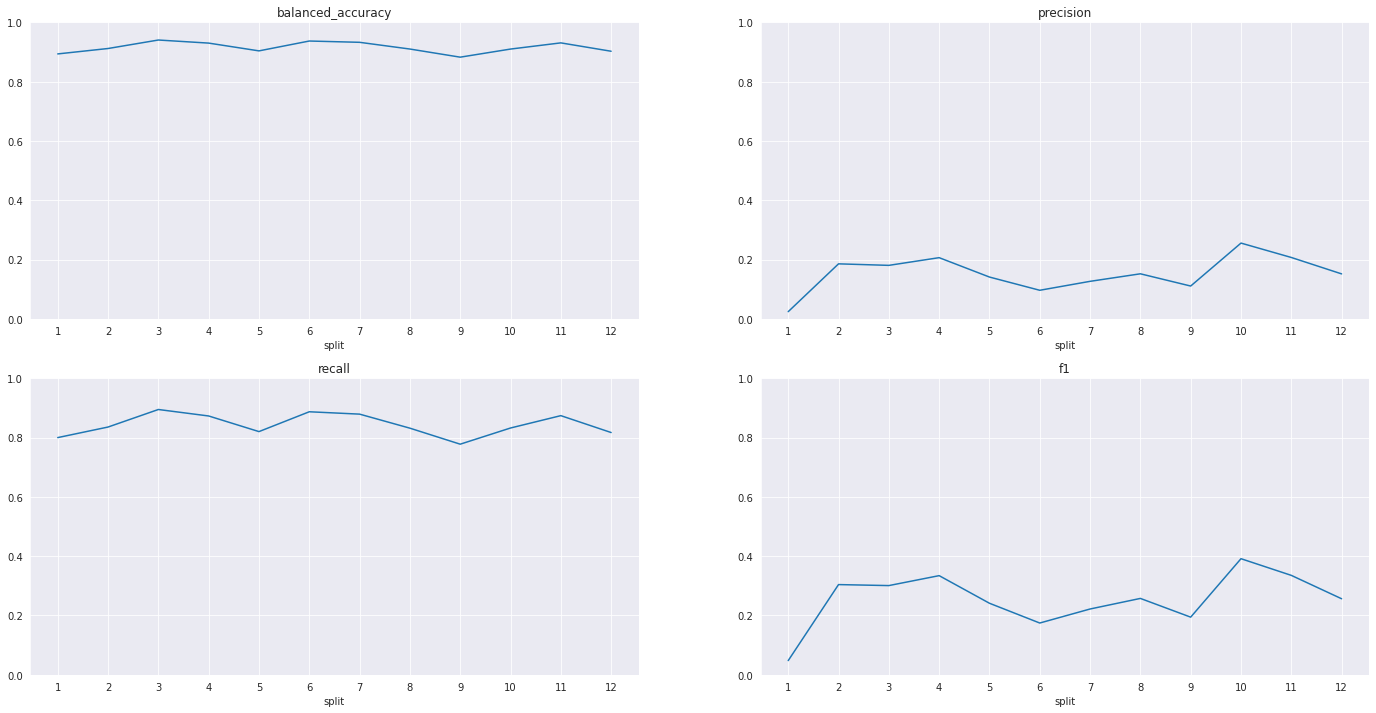

In [105]:
best_score = plot_cross_val_results(xgb_gs,X_train,y_train)

train - balanced acc : 0.9299185551375002 , precision : 0.167944430151788 , recall: 0.8715620827770361, f1: 0.28162208800690247
test - balanced acc : 0.9225979781339926 , precision : 0.16413130504403523 , recall: 0.8570234113712375, f1: 0.27550060475742505


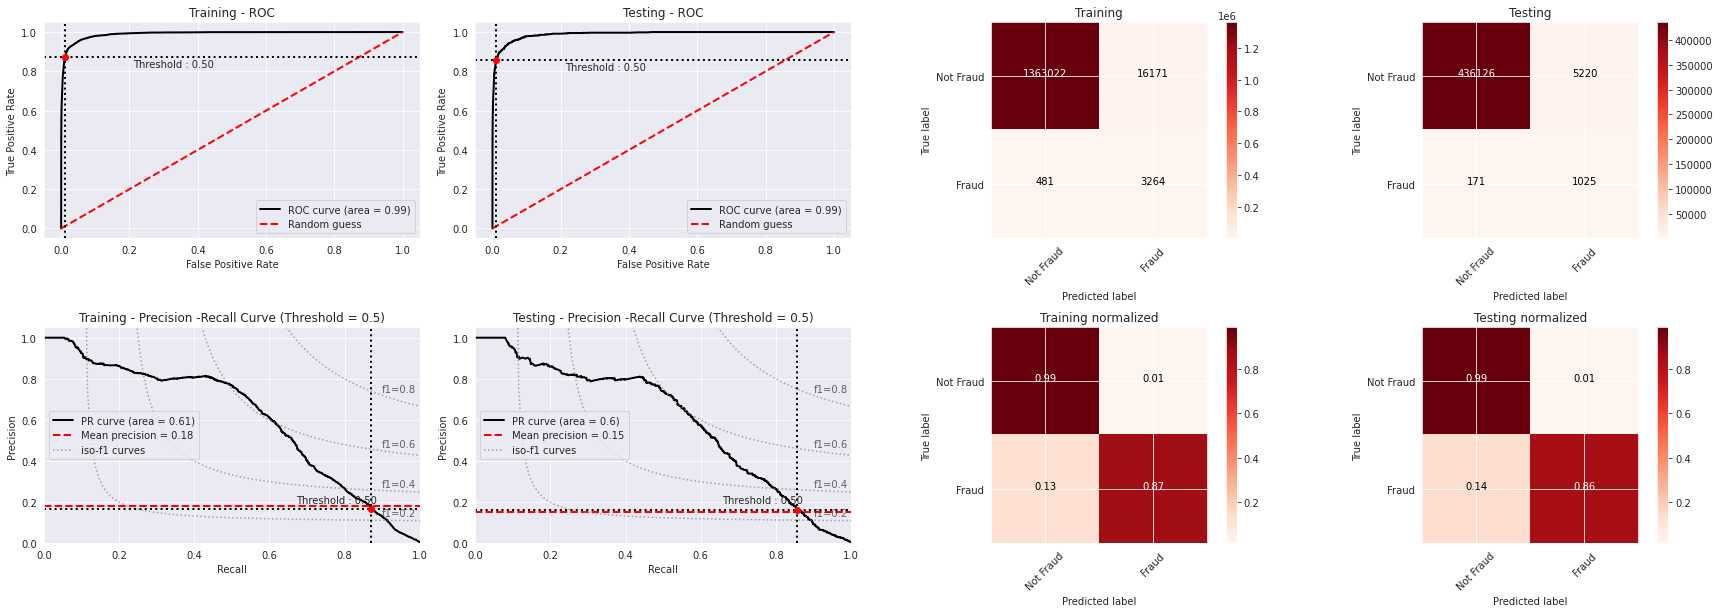

In [106]:
new_row = evaluation_plot(xgb_gs,X_train,X_test,y_train,y_test,'xgboost')
scoring_df = scoring_df.append(new_row,ignore_index = True)

In [278]:
cv = rolling_forecast_test(X_train,X_test,y_train,y_test)
xgb_test_score = rolling_test(xgb_gs,cv,'xgboost',0.89)

In [279]:
xgb_test_score['fp_cost'] = 100*xgb_test_score['FP']
xgb_test_score['estimated_chargebacks'] = average_fraud_amt*xgb_test_score['FN']
xgb_test_score['projected_cost'] = 0*xgb_test_score['TP'] + 0*xgb_test_score['TN'] + xgb_test_score['fp_cost']  + xgb_test_score['estimated_chargebacks']
xgb_test_score['total_actual_cost'] = 0*xgb_test_score['TP'] + 0*xgb_test_score['TN'] + xgb_test_score['fp_cost']  + xgb_test_score['chargebacks']
xgb_test_score['average_chargebacks'] = xgb_test_score['chargebacks']/xgb_test_score['FN']

In [110]:
feature_list = [(feature,f'f{index}') for index,feature in enumerate(X_train.columns)]
xgboost_features = [feature for feature,index in feature_list if index in xgb_gs.best_estimator_.named_steps["xgbclassifier"].get_booster().feature_names]
xgb_gs.best_estimator_.named_steps["xgbclassifier"].get_booster().feature_names = xgboost_features

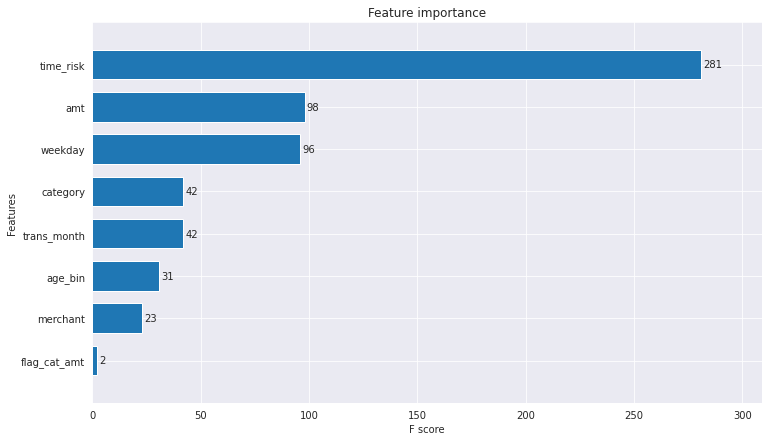

In [111]:
fig,ax = plt.subplots(figsize = (12,7))
plot_importance(xgb_gs.best_estimator_.named_steps["xgbclassifier"].get_booster(), height = 0.7,ax = ax)
plt.rc('font', size=10)

Model Selection

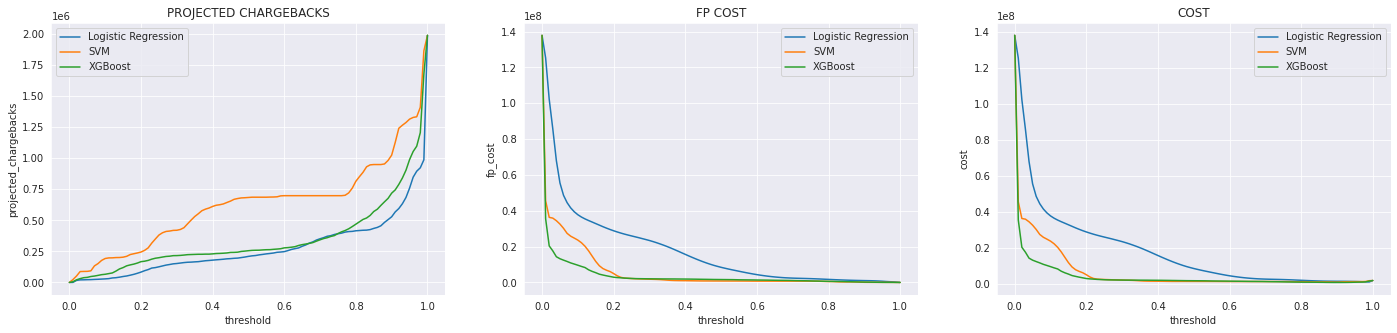

In [340]:
fig, ax = plt.subplots(1,3,figsize = (24,5))
for plot_index,data_column in enumerate(['projected_chargebacks','fp_cost','cost']):
  sns.lineplot(data = log_scores , x = 'threshold' , y = data_column , ax = ax[plot_index], label = 'Logistic Regression')
  sns.lineplot(data = svm_scores , x = 'threshold' , y = data_column , ax = ax[plot_index], label = 'SVM')
  sns.lineplot(data = xgb_scores , x = 'threshold' , y = data_column , ax = ax[plot_index], label = 'XGBoost')
  ax[plot_index].set_title(data_column.replace('_',' ').upper())

1. As we shift our threshold towards 0 , we observe that our model will incur lower costs from being able to correctly identify fraudulent transactions, but at the expense of higher false positives.

2. Higher false positive means that there will be a need to hire more fraud investigators to check all these transactions, thus increasing the total cost to the company.

3. To strike a balance between maximizing True Positives and minimizing False Positives we have used a simple model to find the optimal threshold that our models should have.

4. Each of our false positives is estimated to cost the company $100, and the estimated cost of each false negative will be based on the average observed fraud transaction amount in 2012 to 2014.

5. With those values, we will select the threshold that minimizes the total cost.

### Performance Evaluation:

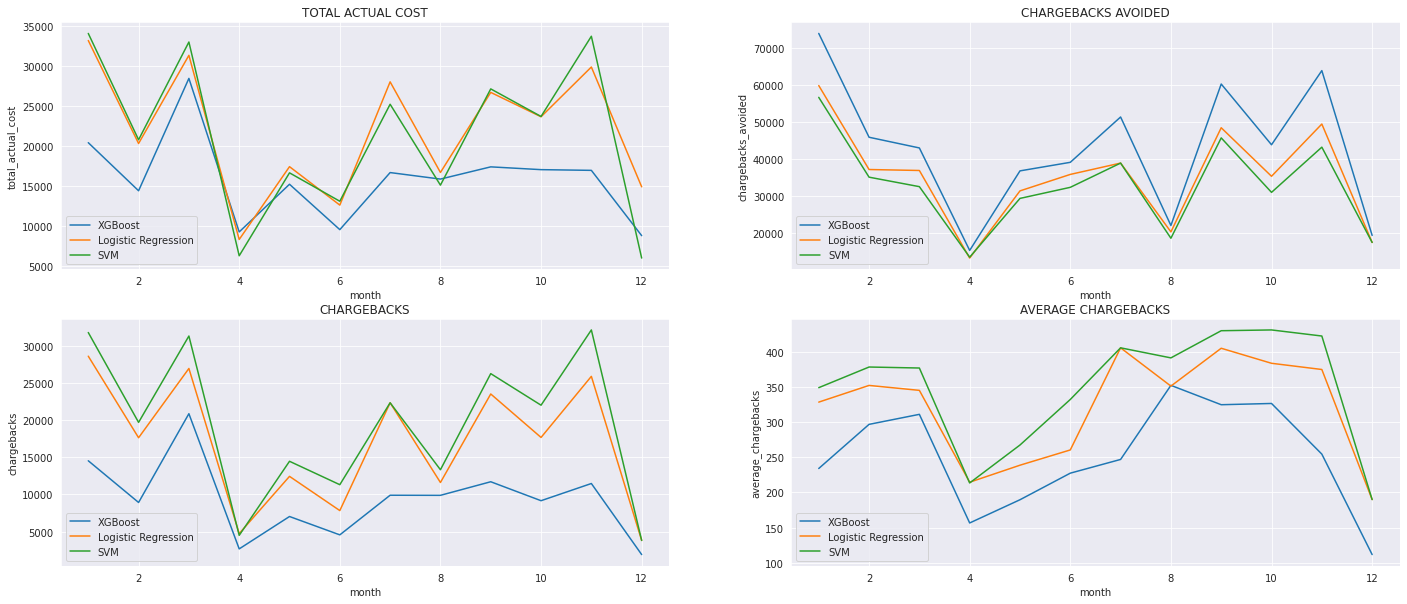

In [303]:
fig, ax = plt.subplots(2,2,figsize = (24,10))
for plot_index,data_column in enumerate(['total_actual_cost','chargebacks_avoided','chargebacks','average_chargebacks']):
  row = plot_index//2
  column = plot_index%2
  sns.lineplot(data = xgb_test_score, x ='month' , y = data_column , ax = ax[row,column] , label = 'XGBoost')
  sns.lineplot(data = log_test_score, x ='month' , y = data_column , ax = ax[row,column] , label = 'Logistic Regression')
  sns.lineplot(data = svm_test_score, x ='month' , y = data_column , ax = ax[row,column] , label = 'SVM')
  ax[row,column].set_title(data_column.replace('_',' ').upper())

In [294]:
print(f'Total cost : logistic regression: ${log_test_score["total_actual_cost"].sum()}, SVM : ${svm_test_score["total_actual_cost"].sum()}, XGBoost :${xgb_test_score["total_actual_cost"].sum()}')
print(f'Chargebacks avoided : logistic regression: ${log_test_score["chargebacks_avoided"].sum()}, SVM : ${svm_test_score["chargebacks_avoided"].sum()}, XGBoost :${xgb_test_score["chargebacks_avoided"].sum()}')

Total cost : logistic regression: $262978.9455566406, SVM : $254693.28295898438, XGBoost :$190026.27490234375
Chargebacks avoided : logistic regression: $424326.0576171875, SVM : $394411.7109375, XGBoost :$514678.740234375


1. XGBoost was more suited towards identifying higher fraudulent transaction amounts; The average chargebacks in each month for our XGBoost model is consistently lower than the other 2 models.

2. Our XGBoost model was able to minimize total actual cost to the company. 

3. If our XGBoost model was deployed in 2015, it would have saved the company $514,678 from identifying fraudulent transactions.

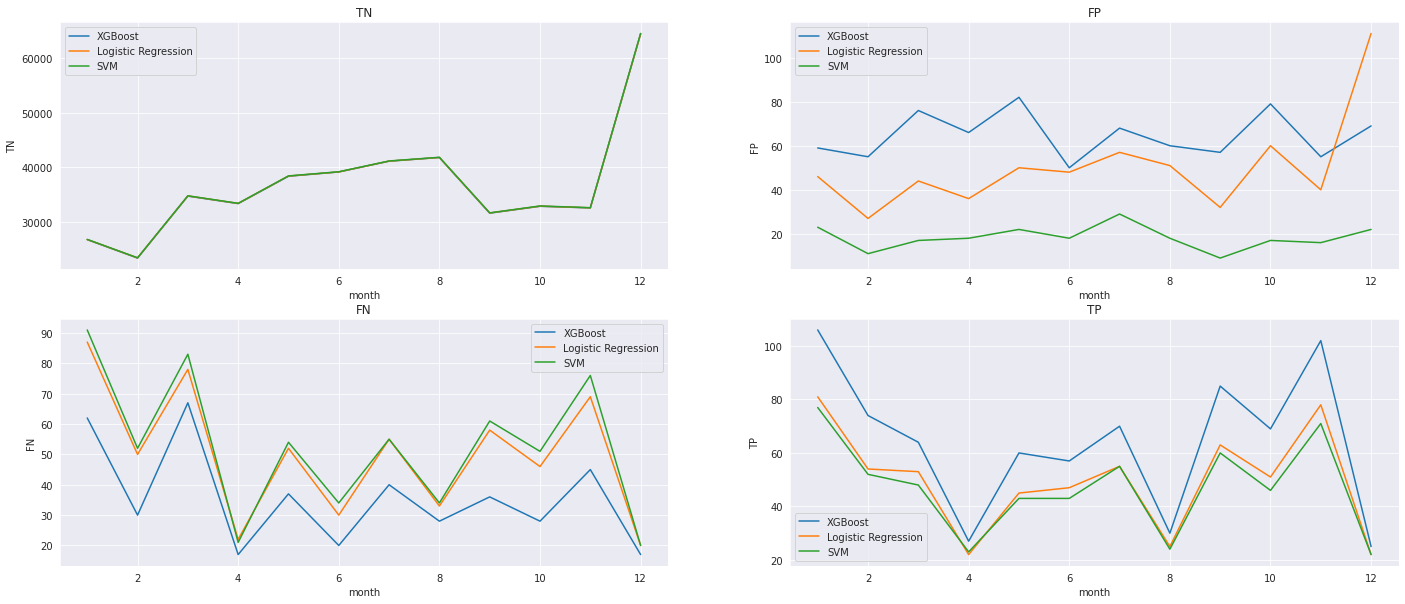

In [304]:
fig, ax = plt.subplots(2,2,figsize = (24,10))
for plot_index,data_column in enumerate(['TN','FP','FN','TP']):
  row = plot_index//2
  column = plot_index%2
  sns.lineplot(data = xgb_test_score, x ='month' , y = data_column , ax = ax[row,column] , label = 'XGBoost')
  sns.lineplot(data = log_test_score, x ='month' , y = data_column , ax = ax[row,column] , label = 'Logistic Regression')
  sns.lineplot(data = svm_test_score, x ='month' , y = data_column , ax = ax[row,column] , label = 'SVM')
  ax[row,column].set_title(data_column.replace('_',' ').upper())

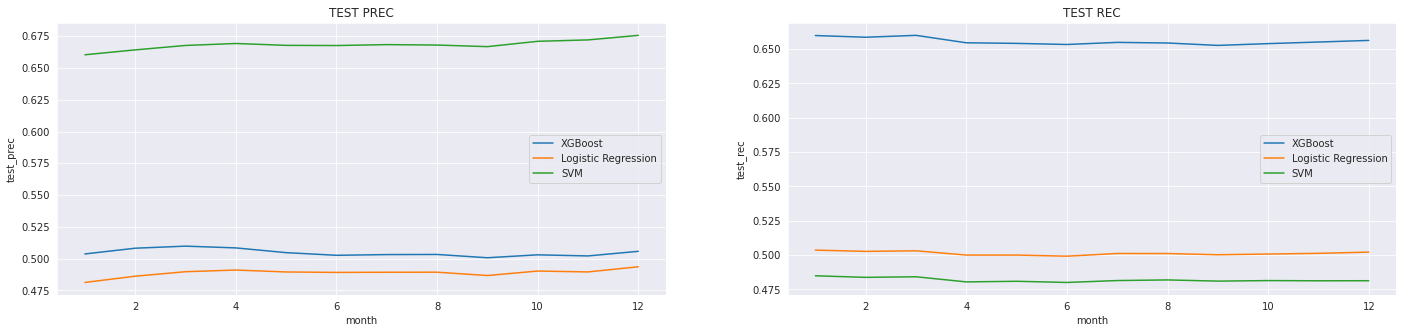

In [310]:
fig, ax = plt.subplots(1,2,figsize = (24,5))
for plot_index,data_column in enumerate(['test_prec','test_rec']):
  sns.lineplot(data = xgb_test_score, x ='month' , y = data_column , ax = ax[plot_index] , label = 'XGBoost')
  sns.lineplot(data = log_test_score, x ='month' , y = data_column , ax = ax[plot_index] , label = 'Logistic Regression')
  sns.lineplot(data = svm_test_score, x ='month' , y = data_column , ax = ax[plot_index] , label = 'SVM')
  ax[plot_index].set_title(data_column.replace('_',' ').upper())

### Future work:

1. Implementation on scala. As our dataset is relatively large, more complex models can be deployed on scala so that the training time can be reduced to something more reasonabe.
2. Explore using other anomaly detection techniques
3. Explore using clustering to identify anomalous activity